<h3>Does precipitation level has anything to do with accident count?</h3>

`US_Accidents_Dec21_updated.csv` and `WeatherEvents_Jan2016-Dec2021.csv` are the main data.<br>
`US_Accidents_Dec21_updated.csv` - accident records for all the states.<br>
`WeatherEvents_Jan2016-Dec2021.csv` - weather events for all the states.<br><br>

Data of 5 cities from different states are extracted and combined.<br>
Producing 5 tables, `[City].csv`, which has **date** (2016-01-01 -> 2021-12-31) as row.

In [95]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [96]:
names = ["Denver", "Miami", "Minneapolis", "New York", "Phoenix"]
category = ['W0000_0600','W0601_1200','W1201_1800','W1801_2359','WS1','WS2','WS3','WS4','AS0000_0600','AS0601_1200','AS1201_1800','AS1801_2359','Accident']
city_count = len(names)
cities = [ 
 pd.read_csv(names[0] + '.csv')
,pd.read_csv(names[1] + '.csv')
,pd.read_csv(names[2] + '.csv')
,pd.read_csv(names[3] + '.csv')
,pd.read_csv(names[4] + '.csv')
]
cities_cat = []

In [97]:
for i in range(city_count):
	cities_cat.append(cities[i][category].astype('category'))

In [98]:
cities_cat[0].describe()

,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,Accident
count,2192,2192,2192,2192,506,342,344,408,2192,2192,2192,2192,2192
unique,7,6,6,6,5,4,4,5,5,5,5,5,2
top,Clear,Clear,Clear,Clear,Light,Light,Light,Light,0,0,0,0,True
freq,1686,1850,1848,1784,394,236,156,304,1244,1165,1495,1929,1476


In [99]:
print("Weather type: ", cities_cat[0]['W0000_0600'].unique(), end ='\n\n')
print("Weather severity: ", cities_cat[0]['WS1'].unique(), end ='\n\n')
print("Accident severity: ", cities_cat[0]['AS0000_0600'].unique())

Weather type:  ['Clear', 'Snow', 'Fog', 'Storm', 'Rain', 'Precipitation', 'Cold']
Categories (7, object): ['Clear', 'Cold', 'Fog', 'Precipitation', 'Rain', 'Snow', 'Storm']

Weather severity:  [NaN, 'Light', 'Moderate', 'Severe', 'UNK', 'Heavy']
Categories (5, object): ['Heavy', 'Light', 'Moderate', 'Severe', 'UNK']

Accident severity:  [0, 2, 3, 4, 1]
Categories (5, int64): [0, 1, 2, 3, 4]


Types of analysis to do (Add if you think it is relevant):
   1. Correlation Matrix / Heatmap [ sb.heatmap(jointDF.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f") ]
   2. No. of Weathers that occur from 2016 to 2021
   3. Total no. of accidents that happened for each weathers 
      [ legnd_data = pkmndata[pkmndata["Legendary"] == True] , print("Number of Legendary Pokemons :", len(legnd_data)) ]
   4. Uni-Variate Linear Regression (Predictor = precipitation)
   5. Goodness of Fit of the Model
   6. Regression with random train-test split
   7. Simple Decision tree (Response = Accident[T/F], Predictor = precipitation)
   8. Classification tree with Random Train-Test Split 
   9. Prediction of Accident 

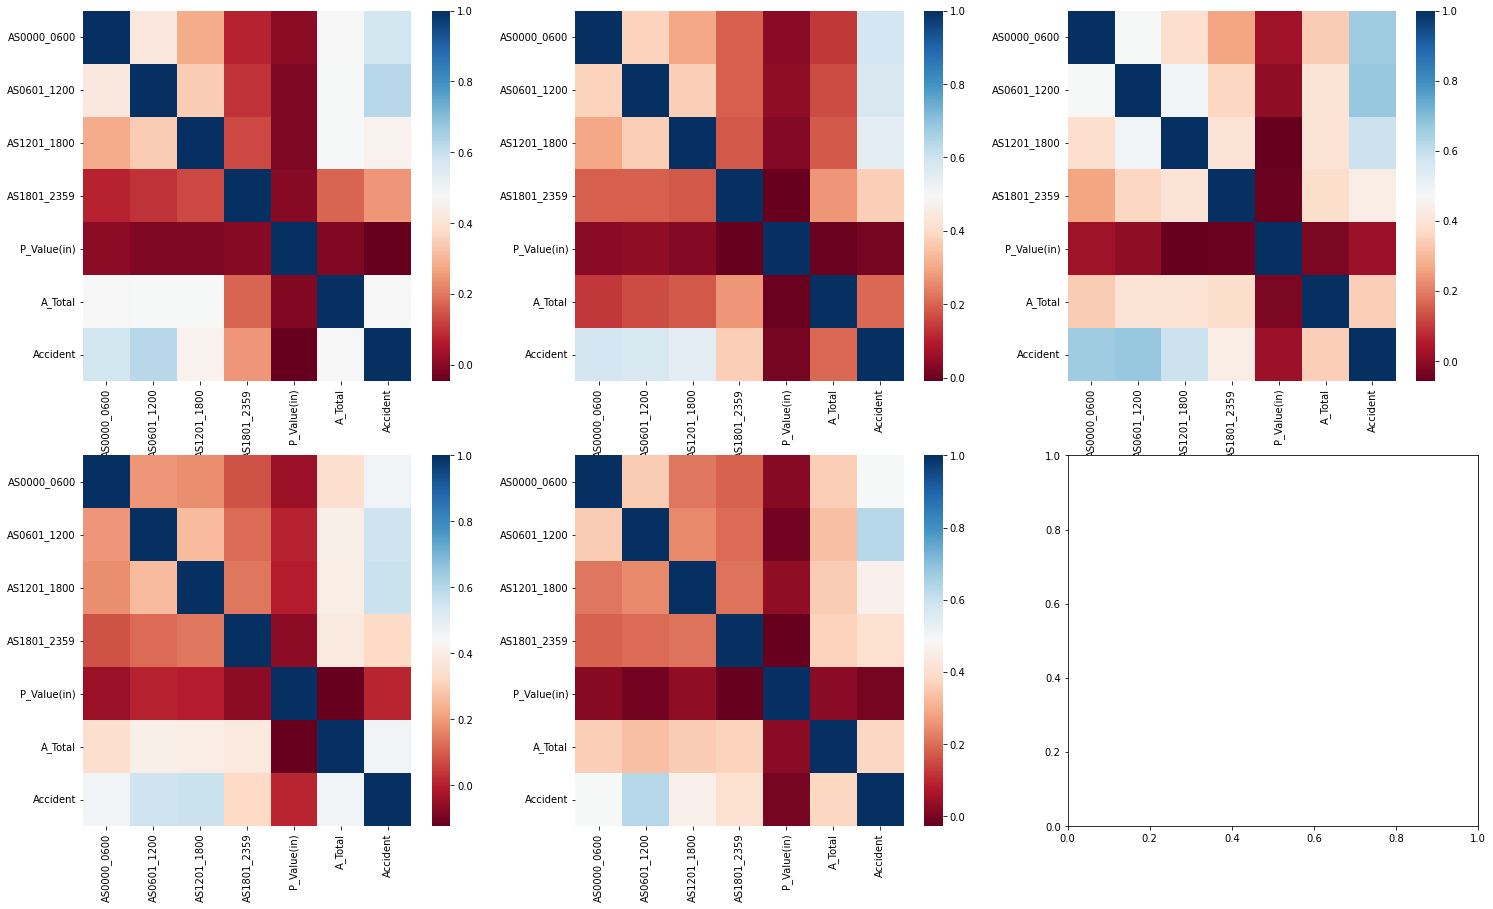

In [100]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))

for i in range(5):
	sb.heatmap(cities[i].corr(), ax = axes[int(i/3),i%3], cmap = "RdBu")

It seems to be have no relationship between preciptation level and accident count.

In [101]:
cities_cat[0].head()

,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,Accident
0,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
1,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
2,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
3,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
4,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False


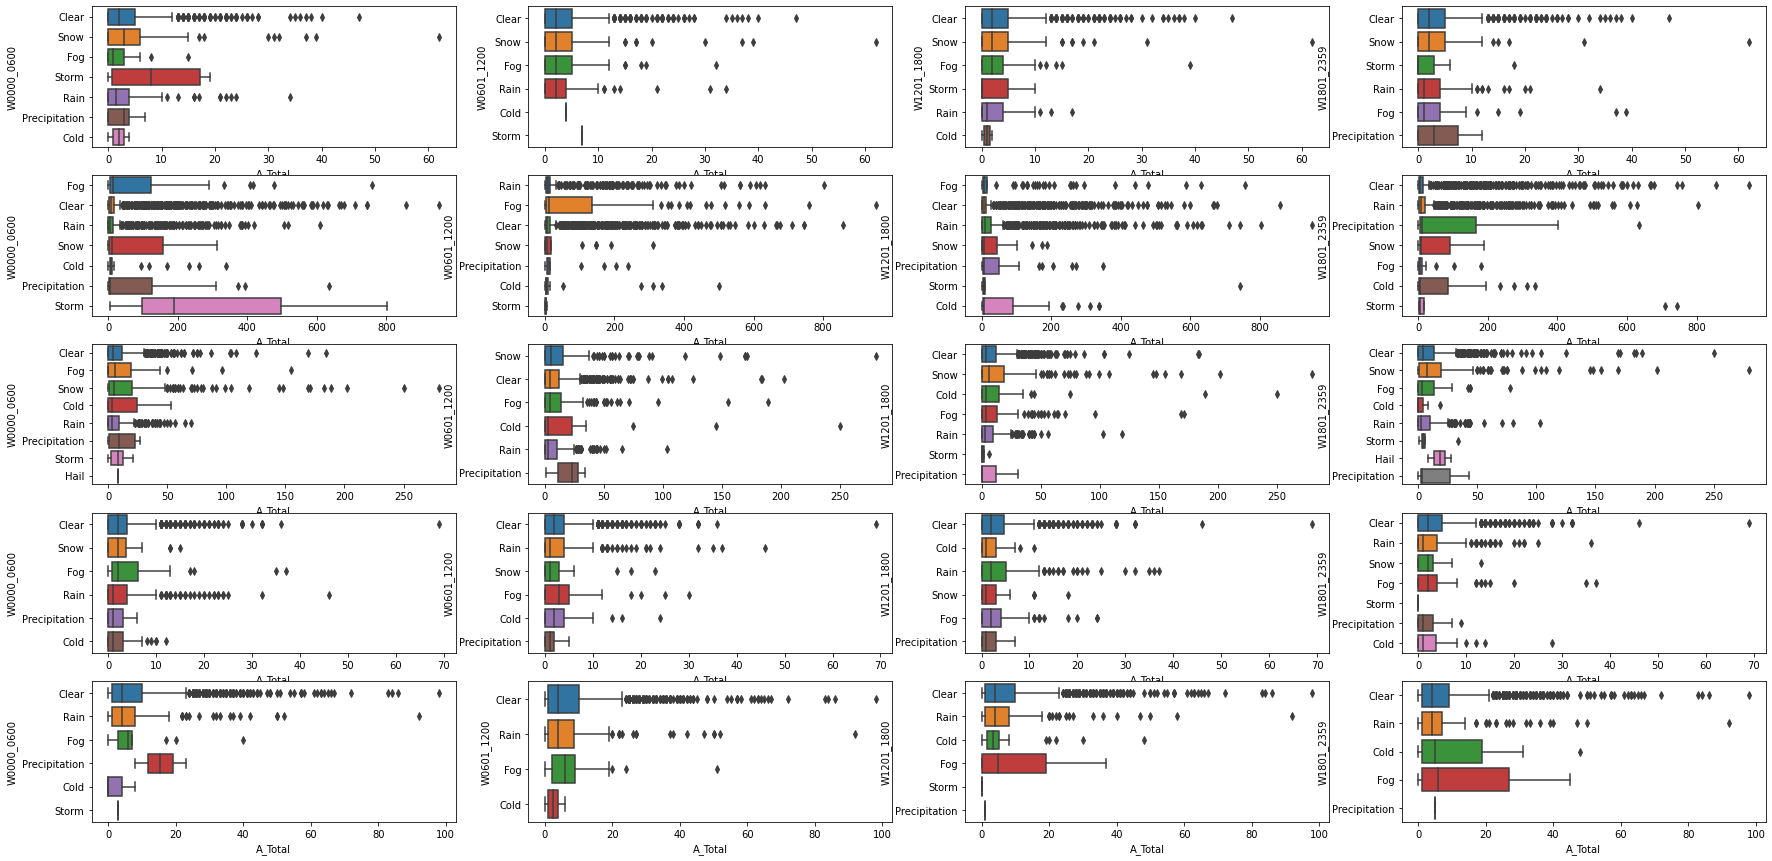

In [106]:
f, axes = plt.subplots(5, 4, figsize=(30, 15))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j] , data = cities[i], orient = 'h', ax = axes[i,j])

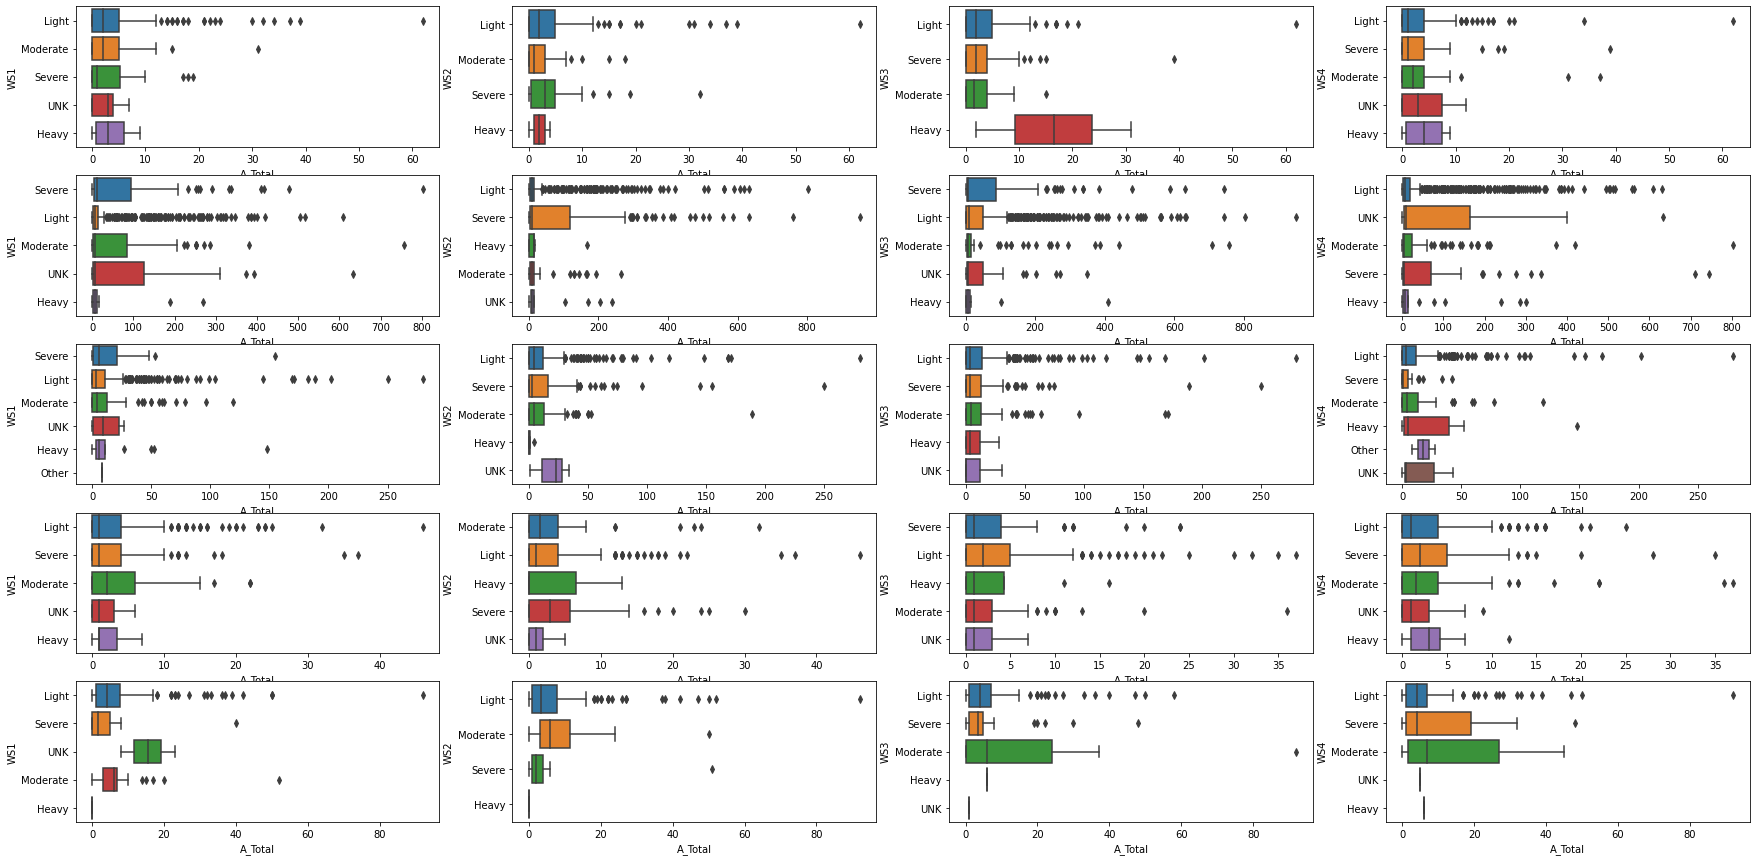

In [107]:
f, axes = plt.subplots(5, 4, figsize=(30, 15))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j + 4] , data = cities[i], orient = 'h', ax = axes[i,j])